In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, PermutationMethod
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks

In [2]:
object_name = 'ZTF18absrlhv'

data = pd.read_csv('detections.csv')
data = data.dropna(subset=['mag_corr']) 
data = data[data['corrected']==True]
cols = []

data.head()

,aid,candid,corrected,dec,dubious,e_dec,e_mag,e_mag_corr,e_mag_corr_ext,e_ra,...,drbversion,magap,magapbig,nid,rb,rbversion,rfid,sigmagap,sigmagapbig,step_id_corr
0,NaN,611156535015015015,True,64.541675,False,NaN,0.178910,100.000000,0.012548,NaN,...,NaN,20.4727,20.5854,611,0.810000,t8_f5_c3,824120250.0,0.3746,0.5135,bulk_1.0.0
1,NaN,733496055015015019,True,64.541870,False,NaN,0.183495,0.005074,0.033825,NaN,...,NaN,19.8069,19.6153,733,0.693333,t8_f5_c3,824120150.0,0.1929,0.2032,bulk_1.0.0
2,NaN,733553345015015017,True,64.541819,False,NaN,0.175932,100.000000,0.020099,NaN,...,NaN,20.0627,20.2764,733,0.866667,t8_f5_c3,824120250.0,0.3222,0.4925,bulk_1.0.0
3,NaN,738530476215015006,True,64.541884,False,NaN,0.189933,0.028325,0.042092,NaN,...,NaN,19.8113,19.7770,738,0.756667,t8_f5_c3,825120162.0,0.2880,0.3534,bulk_1.0.0
4,NaN,738531415015015012,True,64.541867,False,NaN,0.159447,0.004805,0.032894,NaN,...,NaN,19.9195,19.7851,738,0.816667,t8_f5_c3,824120150.0,0.2147,0.2380,bulk_1.0.0


In [3]:
data.columns

Index(['aid', 'candid', 'corrected', 'dec', 'dubious', 'e_dec', 'e_mag',
       'e_mag_corr', 'e_mag_corr_ext', 'e_ra', 'fid', 'has_stamp', 'isdiffpos',
       'mag', 'mag_corr', 'mjd', 'oid', 'parent_candid', 'pid', 'ra', 'sid',
       'tid', 'diffmaglim', 'distnr', 'drb', 'drbversion', 'magap', 'magapbig',
       'nid', 'rb', 'rbversion', 'rfid', 'sigmagap', 'sigmagapbig',
       'step_id_corr'],
      dtype='object')

Text(0.5, 1.0, 'Light Curve of AGN ZTF18absrlhv')

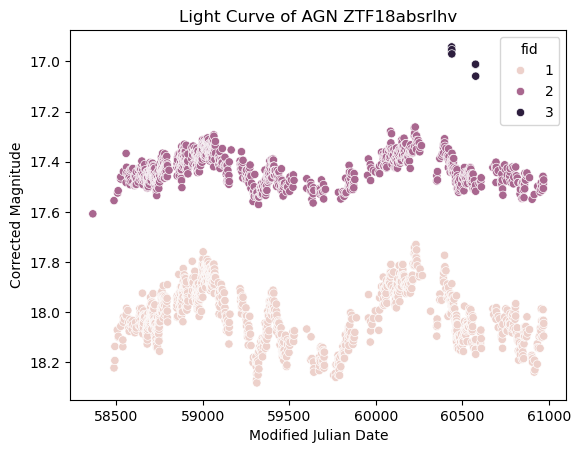

In [4]:
sns.scatterplot(x='mjd', y='mag_corr', hue= 'fid', data=data)
plt.gca().invert_yaxis()
plt.ylabel('Corrected Magnitude')
plt.xlabel('Modified Julian Date')
plt.title(f'Light Curve of AGN {object_name}')

## Separating the data

In [5]:
df_g = data[data['fid'] == 1].copy()
df_r = data[data['fid'] == 2].copy()

def midpoint_band(df_band):
    """Calculate the midpoint of the light curve for a given band."""
    mask = (df_band['mjd'] > 59500) & (df_band['mjd'] < 60000)
    subset = df_band[mask]
    midpoint = subset.nlargest(10, 'mag_corr')['mjd'].median()
    return midpoint

mid_g = midpoint_band(df_g)
mid_r = midpoint_band(df_r)
midpoint = min(mid_g, mid_r) + abs(mid_g - mid_r) / 2

def split_band(df_band, midpoint):
    """Divide the data into two temporal halves based on midpoint."""
    first_half = df_band[df_band['mjd'] < midpoint]
    second_half = df_band[df_band['mjd'] >= midpoint]
    return first_half, second_half

g1, g2 = split_band(df_g, midpoint)
r1, r2 = split_band(df_r, midpoint)

print(f"g-band midpoint (MJD): {mid_g:}")
print(f"r-band midpoint (MJD): {mid_r:}")


g-band midpoint (MJD): 59760.2789930501
r-band midpoint (MJD): 59694.36927660019


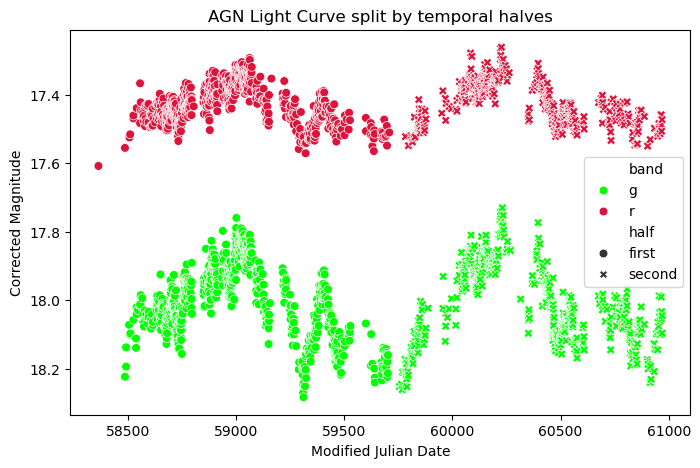

In [6]:
g1 = g1.assign(band='g', half='first')
g2 = g2.assign(band='g', half='second')
r1 = r1.assign(band='r', half='first')
r2 = r2.assign(band='r', half='second')

df_plot = pd.concat([g1, g2, r1, r2], ignore_index=True)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_plot,
    x='mjd',
    y='mag_corr',
    hue='band',     
    style='half',    
    s=40,
    palette={'g':'lime', 'r':'crimson'}
)

plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Corrected Magnitude')
plt.title('AGN Light Curve split by temporal halves')
plt.legend(title='')
plt.show()

### Statistics by halves for each band

In [7]:
stats = df_plot.groupby(['band', 'half'])['mag_corr'].agg(['mean', 'std', 'count'])
print(stats)

                  mean       std  count
band half                              
g    first   17.995685  0.104841    740
     second  18.026869  0.102970    602
r    first   17.427307  0.057029    714
     second  17.424932  0.060802    364


- $H_0$ (Null hypothesis): The mean magnitude of the two halves is the same.

- $H_1$ (Alternative hypothesis): There is a significant variation in the mean magnitude; therefore, the AGN changes its apparent magnitude between the two halves.

- Significance level: $\alpha = 0.005$

- Confidence interval: 99.5%

$$t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

A larger absolute value of $t$ indicates that it is less probable for the two samples to come from populations with the same mean magnitude.

In [9]:
rng = np.random.default_rng(42)
significance_level = 0.005

results = []

for band in ['g', 'r']:
    m1 = df_plot.query("band == @band and half == 'first'")['mag_corr'].dropna().to_numpy()
    m2 = df_plot.query("band == @band and half == 'second'")['mag_corr'].dropna().to_numpy()

    perm = PermutationMethod(n_resamples=9999, rng=rng)

    res = ttest_ind(m1, m2, equal_var=False, method=perm)
    ci = res.confidence_interval(confidence_level=1-significance_level)

    results.append({
        'Band': band,
        'Mean Δ (mag)': m2.mean() - m1.mean(),
        't-stat': res.statistic,
        'p-value': res.pvalue,
        f'CI {1-significance_level:.1%} lower': ci.low,
        f'CI {1-significance_level:.1%} upper': ci.high
    })

# Convert results to DataFrame for better display
summary = pd.DataFrame(results)
summary[f'Significant (p<{significance_level})'] = summary['p-value'] < significance_level
print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


Band  Mean Δ (mag)  t-stat  p-value  CI 99.5% lower  CI 99.5% upper  Significant (p<0.005)
   g        0.0312 -5.4729   0.0002         -0.0472         -0.0152                   True
   r       -0.0024  0.6190   0.5382         -0.0084          0.0132                  False


A two-sample t-test was conducted to assess whether the mean corrected magnitude of the AGN differs between the first and second halves of the observations for each photometric band (g and r). The results are summarized above.

In the g-band, the mean magnitude difference between the two halves is $\Delta = 0.0312$ mag, with $t = −5.47$ and $p = 0.0002$, which is well below the adopted significance level $(\alpha = 0.005)$. The $99.5 \%$ confidence interval for the mean difference $[−0.0472, −0.0152]$ does not include zero, confirming that the mean magnitudes in the two halves are statistically different. This indicates that the AGN does not preserve the same mean magnitude between the two observation windows. In other words, its variability pattern changes over time in the g-band.

Conversely, in the r-band, the mean difference is $\Delta = −0.0024$ mag, with $t = 0.62$ and $p = 0.5382$, which is much greater than the significance threshold. The $99.5 \%$ confidence interval $[−0.0084, 0.0132]$ includes zero, indicating no statistically significant difference between the two halves. Therefore, the AGN maintains a consistent mean magnitude in the r-band, suggesting that its variability pattern remains stable at this wavelength.

# Periodograms

In [10]:
band = 'g'
mask = df_plot['band'] == band

time = df_plot[mask]['mjd'].values
mag = df_plot[mask]['mag_corr'].values
mag_err = df_plot[mask]['e_mag_corr_ext'].values

ls = LombScargle(time, mag, mag_err, nterms=1)

frequency, power = ls.autopower(nyquist_factor=5)

# Convert the frequency to period (in days)
period = 1 / frequency

# More significant periods will have higher power
best_power = np.max(power)
best_period = period[np.argmax(power)]
print(f"Most significant period: {best_period:.3f} days")


fap = ls.false_alarm_probability(best_power, method='baluev')
print(f"False Alarm Probability (FAP) for {best_power}: {fap:.3e}")

Most significant period: 1181.766 days
False Alarm Probability (FAP) for 0.6283734851142679: 1.819e-283


The threshold for peak detection is 0.0797:
    peak_frequency peak_period  peak_power
0         0.000846     1181.77    0.628373
1         1.000883        1.00    0.478791
2         0.001813      551.49    0.372477
3         0.005923      168.82    0.162214
4         0.005117      195.41    0.159471
5         0.994113        1.01    0.151716
6         0.004473      223.58    0.140111
7         1.005154        0.99    0.136836
8         0.002377      420.63    0.132390
9         0.008019      124.71    0.116251
10        0.008663      115.43    0.110657
11        0.003022      330.89    0.088462
12        0.035661       28.04    0.081685


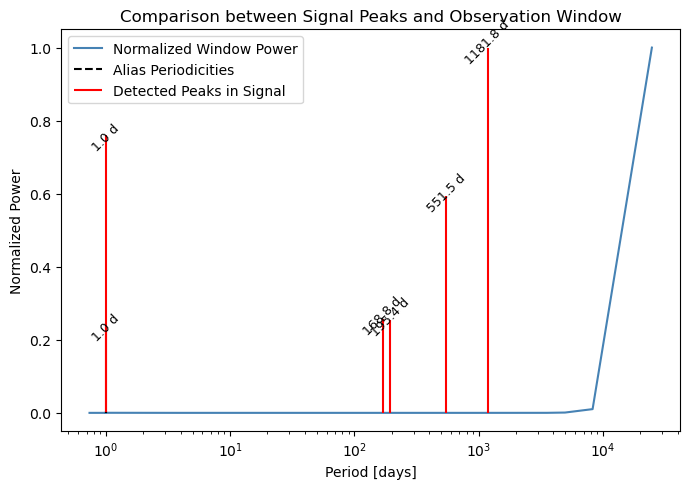

In [11]:
# Set threshold for peak detection
median_val = np.median(power)
noise_std = np.std(power)
threshold = median_val + 3 * noise_std  # 3-sigma criterion
print(f"The threshold for peak detection is {threshold:.4f}:")

# Peak detection in the signal
peaks, props = find_peaks(power, height=threshold)
peak_freqs = frequency[peaks]
peak_powers = power[peaks]

# sorting peaks by power
order = np.argsort(peak_powers)[::-1]
peak_freqs = peak_freqs[order]
peak_powers = peak_powers[order]


df_peaks = pd.DataFrame({
    'peak_frequency': peak_freqs,
    'peak_period': 1 / peak_freqs,
    'peak_power': peak_powers
})
df_peaks['peak_period'] = df_peaks['peak_period'].apply(lambda x: f'{x:.2f}')

df_peaks = df_peaks.drop_duplicates(subset=['peak_period'], keep='first', ignore_index=True)

print(df_peaks)

df_peaks['peak_period'] = df_peaks['peak_period'].astype(float)

# periodogram in the observation window
ls_window = LombScargle(time, np.ones_like(time), center_data=False)
freq_w, power_w = ls_window.autopower(nyquist_factor=5)

# peask in the window
peaks_w, props_w = find_peaks(power_w)
peak_freqs_w = freq_w[peaks_w]
peak_powers_w = power_w[peaks_w]

# Figure
plt.figure(figsize=(7,5))

# Normalizing
norm_window_power = power_w / np.max(power_w)

# Power spectrum in the observation window
plt.plot(1/freq_w, norm_window_power, label='Normalized Window Power', color='steelblue')

# Falses periodicities
plt.vlines(1/peak_freqs_w, 0, peak_powers_w/np.max(power_w),
           color='black', zorder=5, linestyle='--', label='Alias Periodicities')

# Detected peaks in the signal
plt.vlines(df_peaks['peak_period'][:6], 0,
           df_peaks['peak_power'][:6]/np.max(power),
           color='red', label='Detected Peaks in Signal')

# labels for each peak detected in the real signal
for x, y, label in zip(
    df_peaks['peak_period'][:6],
    df_peaks['peak_power'][:6]/np.max(power),
    [f"{p:.1f} d" for p in df_peaks['peak_period'][:6]]
):
    plt.text(
        x, y - 0.05, label,
        fontsize=9, rotation=45, ha='center', va='bottom'
    )


plt.xlabel("Period [days]")
plt.ylabel("Normalized Power")
plt.xscale('log')
plt.legend()
plt.title("Comparison between Signal Peaks and Observation Window")
plt.tight_layout()
plt.show()



[0.01724792 0.01835021 0.0644751 ]


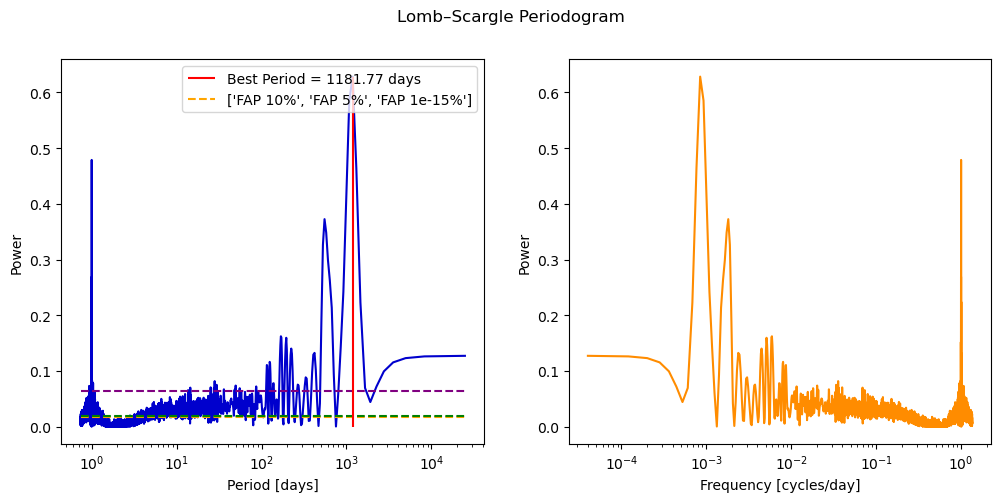

In [12]:
# False alarm probabilities levels
probabilities = [0.1, 0.05, 1e-15]
fap_levels = ls.false_alarm_level(probabilities, method="baluev")
print(fap_levels)

# Plotting the Lomb-Scargle periodogram
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(period, power, color='mediumblue')
ax[0].vlines(best_period, 0, best_power, color='red', zorder=5, label=f'Best Period = {best_period:.2f} days')
ax[0].hlines(fap_levels, xmin=period.min(), xmax=period.max(), colors=['orange','green','purple'], linestyles='dashed',
             label=['FAP 10%','FAP 5%','FAP 1e-15%'])   
ax[0].legend()
ax[0].set_xlabel('Period [days]')
ax[0].set_ylabel('Power')
ax[0].set_xscale('log')

ax[1].plot(frequency, power, color='darkorange')
ax[1].set_xlabel('Frequency [cycles/day]')
ax[1].set_ylabel('Power')
ax[1].set_xscale('log')

plt.suptitle('Lomb–Scargle Periodogram')

plt.show()

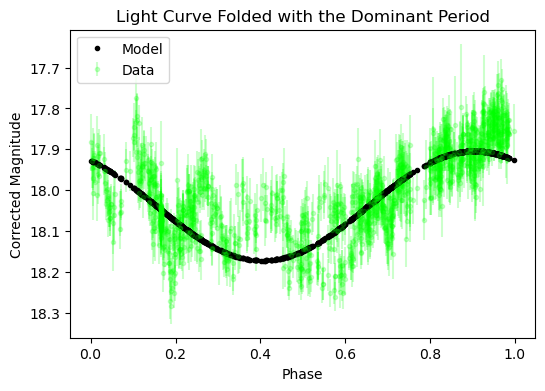

In [13]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(min(time), max(time), 500)
y_fit = ls.model(t_fit, best_frequency)

phase = (time * best_frequency) % 1  # fase en [0,1)

plt.figure(figsize=(6,4))
plt.errorbar(phase, mag, yerr=mag_err, fmt='.', color='lime', alpha=0.2, label='Data')
plt.plot(phase, ls.model(time, best_frequency), 'k.', label='Model')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Corrected Magnitude')
plt.legend()
plt.title('Light Curve Folded with the Dominant Period')
plt.show()


[ 0.0102719   0.07585963 -0.11052951]
Autocoherence test between Lomb–Scargle model and manual reconstruction: PASS
theta1 (sin coef) = 0.010272
theta2 (cos coef) = 0.075860
Amplitude A = 0.076552 mag (semi-amplitude)
Phase phi = 1.4362 rad  -> phase fraction = 0.2286
Offset (mean magnitude) = 18.027983 mag


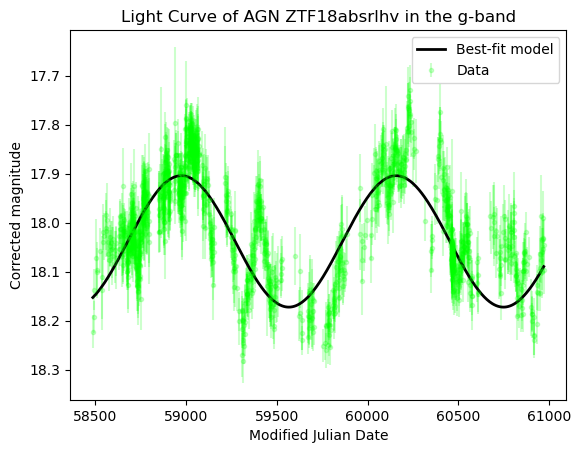

In [14]:
theta = ls.model_parameters(best_frequency)  # Coefficentes of Sin and Cos terms
print(theta)

offset = ls.offset()

design_matrix = ls.design_matrix(best_frequency, t_fit)

result = np.allclose(y_fit, offset + design_matrix.dot(theta))
print(f"Autocoherence test between Lomb–Scargle model and manual reconstruction: {'PASS' if result else 'FAIL'}")

model_fit = offset + design_matrix.dot(theta)

theta1 = theta[0]   # coefficient of sin(2π f t)
theta2 = theta[1]   # coefficient of cos(2π f t)

# Amplitude and Phase
A = np.hypot(theta1, theta2)                  # sqrt(theta1^2 + theta2^2)
phi = np.arctan2(theta2, theta1)              # radians

# Convert phase to a period fraction
phase_frac = (phi / (2*np.pi)) % 1.0

# offset 
offset = ls.offset()

print(f"theta1 (sin coef) = {theta1:.6f}")
print(f"theta2 (cos coef) = {theta2:.6f}")
print(f"Amplitude A = {A:.6f} mag (semi-amplitude)")
print(f"Phase phi = {phi:.4f} rad  -> phase fraction = {phase_frac:.4f}")
print(f"Offset (mean magnitude) = {offset:.6f} mag")



plt.errorbar(time, mag,
             yerr=mag_err, fmt='.', color='lime', alpha= 0.2, label='Data')
plt.plot(t_fit, model_fit, 'k-', lw=2, label='Best-fit model')
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Corrected magnitude')
plt.title(f'Light Curve of AGN {object_name} in the {band}-band')
plt.legend()
plt.show()


## Secondary frequency

<ErrorbarContainer object of 3 artists>

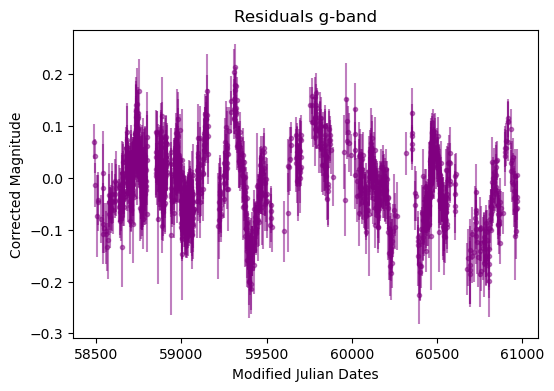

In [15]:
model1 = ls.model(time, best_frequency)
residuals = mag - model1


plt.figure(figsize=(6,4))
plt.title(f"Residuals {band}-band")
plt.xlabel("Modified Julian Dates")
plt.ylabel("Corrected Magnitude")
plt.errorbar(time, residuals,
             yerr=mag_err, fmt='.', color='purple', alpha=0.5, label='Residuals')

Most significant period: 195.410 days
False Alarm Probability (FAP) for 0.2056607573431033: 5.246e-63


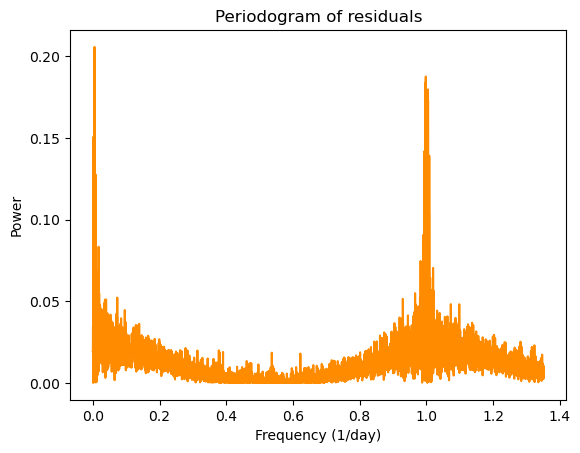

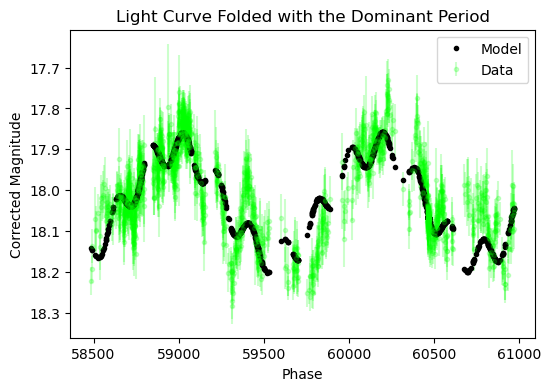

In [16]:
ls_res = LombScargle(time, residuals, mag_err)

frequency_res, power_res = ls_res.autopower(nyquist_factor=5)

# Convert the frequency to period (in days)
period_res = 1 / frequency_res

# More significant periods will have higher power
best_power_res = np.max(power_res)
best_period_res = period_res[np.argmax(power_res)]
best_frequency_res = frequency_res[np.argmax(power_res)]
print(f"Most significant period: {best_period_res:.3f} days")

fap = ls_res.false_alarm_probability(best_power_res, method='baluev')
print(f"False Alarm Probability (FAP) for {best_power_res}: {fap:.3e}")

plt.plot(frequency_res, power_res, color='darkorange')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Periodogram of residuals")
plt.show()


model2 = ls_res.model(time, best_frequency_res)
combined_model = model1 + model2


plt.figure(figsize=(6,4))
plt.errorbar(time, mag, yerr=mag_err, fmt='.', color='lime', alpha=0.2, label='Data')
plt.plot(time, combined_model, 'k.', label='Model')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Corrected Magnitude')
plt.legend()
plt.title('Light Curve Folded with the Dominant Period')
plt.show()


## Band r

Most significant period: 1239.981 days
False Alarm Probability (FAP) for 0.5710553635367486: 1.830e-193
[0.02088342 0.02225282 0.07916332]


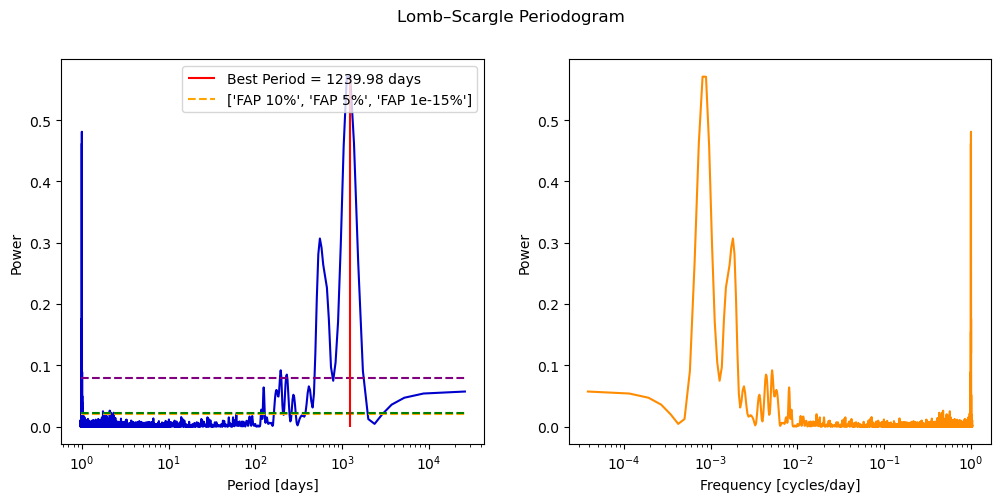

In [17]:
band = 'r'
mask = df_plot['band'] == band

time = df_plot[mask]['mjd'].values
mag = df_plot[mask]['mag_corr'].values
mag_err = df_plot[mask]['e_mag_corr_ext'].values

ls = LombScargle(time, mag, mag_err, nterms=1)

frequency, power = ls.autopower(nyquist_factor=5)

# Convert the frequency to period (in days)
period = 1 / frequency

# More significant periods will have higher power
best_power = np.max(power)
best_period = period[np.argmax(power)]
print(f"Most significant period: {best_period:.3f} days")


fap = ls.false_alarm_probability(best_power, method='baluev')
print(f"False Alarm Probability (FAP) for {best_power}: {fap:.3e}")


# False alarm probabilities levels
probabilities = [0.1, 0.05, 1e-15]
fap_levels = ls.false_alarm_level(probabilities, method="baluev")
print(fap_levels)

# Plotting the Lomb-Scargle periodogram
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(period, power, color='mediumblue')
ax[0].vlines(best_period, 0, best_power, color='red', zorder=5, label=f'Best Period = {best_period:.2f} days')
ax[0].hlines(fap_levels, xmin=period.min(), xmax=period.max(), colors=['orange','green','purple'], linestyles='dashed',
             label=['FAP 10%','FAP 5%','FAP 1e-15%'])   
ax[0].legend()
ax[0].set_xlabel('Period [days]')
ax[0].set_ylabel('Power')
ax[0].set_xscale('log')

ax[1].plot(frequency, power, color='darkorange')
ax[1].set_xlabel('Frequency [cycles/day]')
ax[1].set_ylabel('Power')
ax[1].set_xscale('log')

plt.suptitle('Lomb–Scargle Periodogram')

plt.show()

The threshold for peak detection is 0.0581:
   peak_frequency peak_period  peak_power
0        0.000806     1239.98    0.571055
1        1.001897        1.00    0.481140
2        0.001805      554.03    0.306924
3        0.005108      195.79    0.091878
4        0.994754        1.01    0.089170
5        0.004340      230.44    0.084921
6        1.005046        0.99    0.080049
7        0.002419      413.33    0.065730
8        0.008026      124.59    0.063943
9        0.005722      174.76    0.059802


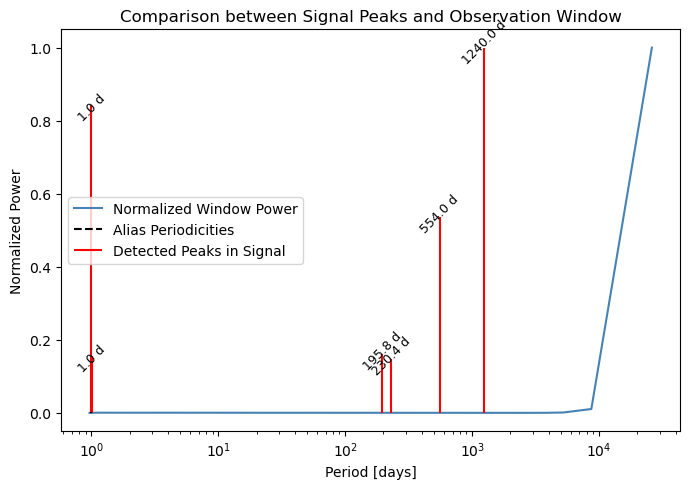

In [18]:
# Set threshold for peak detection
median_val = np.median(power)
noise_std = np.std(power)
threshold = median_val + 3 * noise_std  # 3-sigma criterion
print(f"The threshold for peak detection is {threshold:.4f}:")

# Peak detection in the signal
peaks, props = find_peaks(power, height=threshold)
peak_freqs = frequency[peaks]
peak_powers = power[peaks]

# sorting peaks by power
order = np.argsort(peak_powers)[::-1]
peak_freqs = peak_freqs[order]
peak_powers = peak_powers[order]


df_peaks = pd.DataFrame({
    'peak_frequency': peak_freqs,
    'peak_period': 1 / peak_freqs,
    'peak_power': peak_powers
})
df_peaks['peak_period'] = df_peaks['peak_period'].apply(lambda x: f'{x:.2f}')

df_peaks = df_peaks.drop_duplicates(subset=['peak_period'], keep='first', ignore_index=True)

print(df_peaks)

df_peaks['peak_period'] = df_peaks['peak_period'].astype(float)

# periodogram in the observation window
ls_window = LombScargle(time, np.ones_like(time), center_data=False)
freq_w, power_w = ls_window.autopower(nyquist_factor=5)

# peask in the window
peaks_w, props_w = find_peaks(power_w)
peak_freqs_w = freq_w[peaks_w]
peak_powers_w = power_w[peaks_w]

# Figure
plt.figure(figsize=(7,5))

# Normalizing
norm_window_power = power_w / np.max(power_w)

# Power spectrum in the observation window
plt.plot(1/freq_w, norm_window_power, label='Normalized Window Power', color='steelblue')

# Falses periodicities
plt.vlines(1/peak_freqs_w, 0, peak_powers_w/np.max(power_w),
           color='black', zorder=5, linestyle='--', label='Alias Periodicities')

# Detected peaks in the signal
plt.vlines(df_peaks['peak_period'][:6], 0,
           df_peaks['peak_power'][:6]/np.max(power),
           color='red', label='Detected Peaks in Signal')

# labels for each peak detected in the real signal
for x, y, label in zip(
    df_peaks['peak_period'][:6],
    df_peaks['peak_power'][:6]/np.max(power),
    [f"{p:.1f} d" for p in df_peaks['peak_period'][:6]]
):
    plt.text(
        x, y - 0.05, label,
        fontsize=9, rotation=45, ha='center', va='bottom'
    )


plt.xlabel("Period [days]")
plt.ylabel("Normalized Power")
plt.xscale('log')
plt.legend()
plt.title("Comparison between Signal Peaks and Observation Window")
plt.tight_layout()
plt.show()



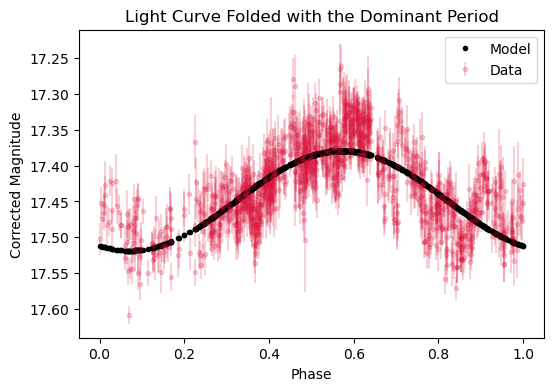

In [19]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(min(time), max(time), 500)
y_fit = ls.model(t_fit, best_frequency)

phase = (time * best_frequency) % 1  # fase en [0,1)

plt.figure(figsize=(6,4))
plt.errorbar(phase, mag, yerr=mag_err, fmt='.', color='crimson', alpha=0.2, label='Data')
plt.plot(phase, ls.model(time, best_frequency), 'k.', label='Model')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('Corrected Magnitude')
plt.legend()
plt.title('Light Curve Folded with the Dominant Period')
plt.show()


[0.01720473 0.03010152 0.06291535]
Autocoherence test between Lomb–Scargle model and manual reconstruction: PASS
theta1 (sin coef) = 0.017205
theta2 (cos coef) = 0.030102
Amplitude A = 0.034671 mag (semi-amplitude)
Phase phi = 1.0516 rad  -> phase fraction = 0.1674
Offset (mean magnitude) = 17.431691 mag


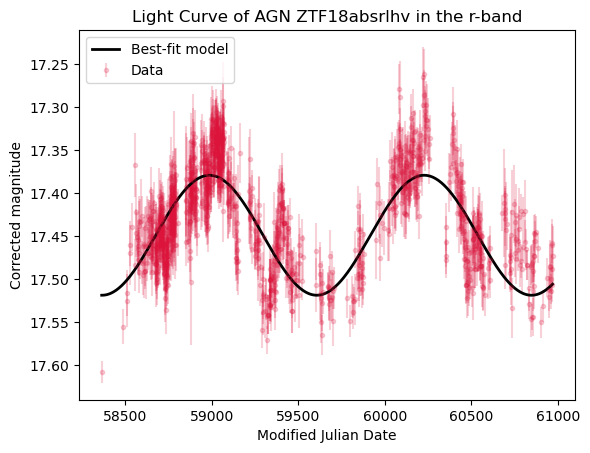

In [20]:
theta = ls.model_parameters(best_frequency)  # Coefficentes of Sin and Cos terms
print(theta)

offset = ls.offset()

design_matrix = ls.design_matrix(best_frequency, t_fit)

result = np.allclose(y_fit, offset + design_matrix.dot(theta))
print(f"Autocoherence test between Lomb–Scargle model and manual reconstruction: {'PASS' if result else 'FAIL'}")

model_fit = offset + design_matrix.dot(theta)

theta1 = theta[0]   # coefficient of sin(2π f t)
theta2 = theta[1]   # coefficient of cos(2π f t)

# Amplitude and Phase
A = np.hypot(theta1, theta2)                  # sqrt(theta1^2 + theta2^2)
phi = np.arctan2(theta2, theta1)              # radians

# Convert phase to a period fraction
phase_frac = (phi / (2*np.pi)) % 1.0

# offset 
offset = ls.offset()

print(f"theta1 (sin coef) = {theta1:.6f}")
print(f"theta2 (cos coef) = {theta2:.6f}")
print(f"Amplitude A = {A:.6f} mag (semi-amplitude)")
print(f"Phase phi = {phi:.4f} rad  -> phase fraction = {phase_frac:.4f}")
print(f"Offset (mean magnitude) = {offset:.6f} mag")



plt.errorbar(time, mag,
             yerr=mag_err, fmt='.', color='crimson', alpha= 0.2, label='Data')
plt.plot(t_fit, model_fit, 'k-', lw=2, label='Best-fit model')
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Corrected magnitude')
plt.title(f'Light Curve of AGN {object_name} in the {band}-band')
plt.legend()
plt.show()


<ErrorbarContainer object of 3 artists>

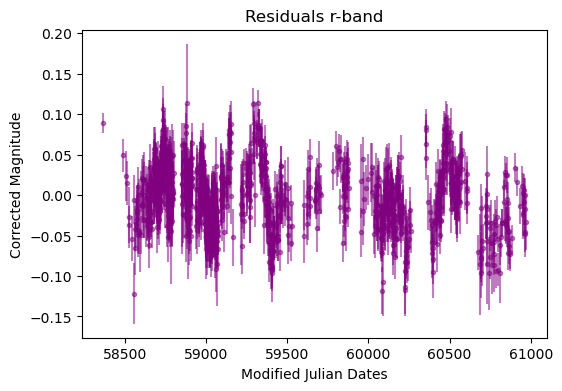

In [21]:
model1 = ls.model(time, best_frequency)
residuals = mag - model1


plt.figure(figsize=(6,4))
plt.title(f"Residuals {band}-band")
plt.xlabel("Modified Julian Dates")
plt.ylabel("Corrected Magnitude")
plt.errorbar(time, residuals,
             yerr=mag_err, fmt='.', color='purple', alpha=0.5, label='Residuals')